In [1]:
#TODO
#check moving average to ensure no overlaps between series or years
#find way to determine upwelling front depth, compare with nitrate
#exponential wind fit?
#better colormap
#ship data comparisons
#

In [2]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.cm as mpcm
from matplotlib.dates import DateFormatter
import numpy as np   
import re
import requests
import xarray as xr 
#from airsea import stress
from scipy.optimize import curve_fit as cs
from physoce import tseries as ts
from cmocean import cm
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as st
from bs4 import BeautifulSoup

In [3]:
def list_files(url, tag=r'.*\.nc$'):
    """
    Function to create a list of the netCDF data files in the THREDDS catalog
    created by a request to the M2M system.

    :param url: URL to a THREDDS catalog specific to a data request
    :param tag: regex pattern used to distinguish files of interest
    :return: list of files in the catalog with the URL path set relative to the
        catalog
    obtained from 2022 OOIFB workshop 
    """
    with requests.session() as s:
        page = s.get(url).text

    soup = BeautifulSoup(page, 'html.parser')
    pattern = re.compile(tag)
    nc_files = [node.get('href') for node in soup.find_all('a', text=pattern)]
    nc_files = [re.sub('catalog.html\?dataset=', '', file) for file in nc_files]
    return nc_files

#the following taken from Tom Connolly for principal axis analysis of wind data
def wind_uv_from_spddir(wspd,wdir):
    theta = np.array(wdir)
    theta = theta*np.pi/180
    x = np.sin(theta)
    y = np.cos(theta)
    theta_cart = np.arctan2(y,x)
    u = -wspd*np.cos(theta_cart)
    v = -wspd*np.sin(theta_cart)
    return u,v

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

def logistic(x, a, b, c):
    #x=input array, a=growth rate, b=max value, c=center of curve
    output = b/(1+np.exp(-a*x-c))
    return output

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Nitrate Analysis

In [4]:
#get nitrate data
# setup defaults to use in subsequent data queries
refdes = "CE01ISSP-SP001-06-NUTNRJ000";
method = "recovered_cspp";
stream = "nutnr_j_cspp_instrument_recovered";

# construct the OOI Gold Copy THREDDS catalog URL for this data set
base_url = "https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/";
url = base_url + ('-').join([refdes, method, stream]) + '/catalog.html'
url #check to ensure URL is correct

'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/catalog.html'

In [5]:
tag = r'NUTNRJ000.*.nc$' #setup regex for files we want (*=anything,$=end of line)
nc_files = list_files(url, tag)
file_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/'
nc_url = [file_url + i + '#mode=bytes' for i in nc_files] #combine files, add mode to ensure download works
#nc_url #can check urls here

In [6]:
ds,mask = [],[]  #empty arrays for data masks and datasets
for i,f in enumerate(nc_url):
    r = requests.get(f, timeout=(3.05, 120)) #request url
    if r.ok:                                #ensure request worked
        ds.append(xr.load_dataset(io.BytesIO(r.content))) #load datasets
        ds[i].swap_dims({'obs':'time'}) #swap dims
        mask.append((~np.isnan(ds[i]['nitrate_concentration'].values)) & (ds[i]['nitrate_concentration'].values<=100) & (ds[i]['deployment'].values!=16)) #mask for selected conditions
        labels = [d['deployment'][0].values for d in ds]   #create deployment labels for plotting (add other useful labels here too)

In [7]:
mask = []
for i,d in enumerate(ds):
    mask.append((~np.isnan(ds[i]['nitrate_concentration'].values)) & (ds[i]['nitrate_concentration'].values<=100)) #& (ds[i]['deployment'].values!=16)) #mask for selected conditions

In [8]:
for i,n in enumerate(ds):
    ds[i] = n.swap_dims({'obs':'time'})

In [9]:
#If pre-binned nitrate dataset is available, use the below code
ncfile = 'C:/Users/asche/Desktop/Research/Graduate Research/logistic nitrate/data/binned_nitrate_data.nc'
ds_nitr_bin = xr.open_dataset(ncfile)
pressure_grid = ds_nitr_bin['depth']
time_grid = ds_nitr_bin['time']
nitrate_grid = ds_nitr_bin['nitrate']

## Nitrate Binning Code
Change from raw->code if pre-binned nitrate is not available (this takes quite a bit of time!)

(0.0, 70.0)

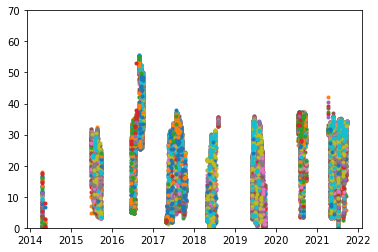

In [10]:
for i,nc in enumerate(nitrate_grid.T):
    plt.plot(time_grid, nc, '.')
plt.ylim([0,70])    

# ADCP Analysis

# Wind Analysis

In [11]:
#get wind data
#construct the NDBC THREDDS catalog URL for this data set
url_w = "https://dods.ndbc.noaa.gov/thredds/catalog/data/stdmet/nwpo3/catalog.html";
url_w #check to ensure URL is correct

'https://dods.ndbc.noaa.gov/thredds/catalog/data/stdmet/nwpo3/catalog.html'

In [12]:
tag = r'20[1][4-9].*\.nc$|20[2][0-2].*\.nc$' #setup regex for files we want (.=anything,, *=repeats, $=end of line, |=or)
nc_files = list_files(url_w, tag)
file_url = 'https://dods.ndbc.noaa.gov/thredds/fileServer/'
nc_url_w = [file_url + i + '#mode=bytes' for i in nc_files] #combine files, add mode to ensure download works
nc_url_w #can check urls here
#https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/nwpo3/nwpo3h2014.nc

['https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2014.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2015.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2016.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2017.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2018.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2019.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2020.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2021.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2022.nc#mode=bytes']

In [13]:
ds_w,mask_w = [],[]  #empty arrays for data masks and datasets
for i,f in enumerate(nc_url_w):
    r = requests.get(f, timeout=(3.05, 120)) #request url
    if r.ok:                                #ensure request worked
        ds_w.append(xr.load_dataset(io.BytesIO(r.content))) #load datasets
        #ds_w[i].swap_dims({'obs':'time'}) #swap dims
        #mask_w.append((~np.isnan(ds[i]['nitrate_concentration'].values)) & (ds[i]['nitrate_concentration'].values<=100) & (ds[i]['deployment'].values!=16)) #mask for selected conditions
        #labels = [d['deployment'][0].values for d in ds]   #create deployment labels for plotting (add other useful labels here too)

In [14]:
for i,w in enumerate(ds_w):
    ds_w[i] = w.squeeze()

In [15]:
for i,w in enumerate(ds_w):
    ds_w[i]['wind_east'],ds_w[i]['wind_north'] = wind_uv_from_spddir(w['wind_spd'], w['wind_dir'])
    #plt.figure(i)
    #plt.plot(w['wind_east'], w['wind_north'])

In [16]:
for i,w in enumerate(ds_w):
    #plt.figure(i)
    theta, major, minor = princax(w['wind_east'], w['wind_north'])
    ds_w[i]['cs'],ds_w[i]['as'] = rot(w['wind_east'], w['wind_north'], -theta+90)
    #plt.plot(w['wind_east'], w['wind_north'])
    #plt.plot(w['cs'], w['as'])

In [17]:
#resample to 1D time intervals with mean method
ds_w_r = []
for i,w in enumerate(ds_w):
    ds_w_r.append(w.resample(time="1D").mean())  

In [18]:
ds_w_rs = xr.concat(ds_w_r, dim='time') #concatenate wind datasets onto one time series

# Nitrate Wind Fit Analysis

Text(0, 0.5, 'Nitrate Concentration [$mmol/m^3$]')

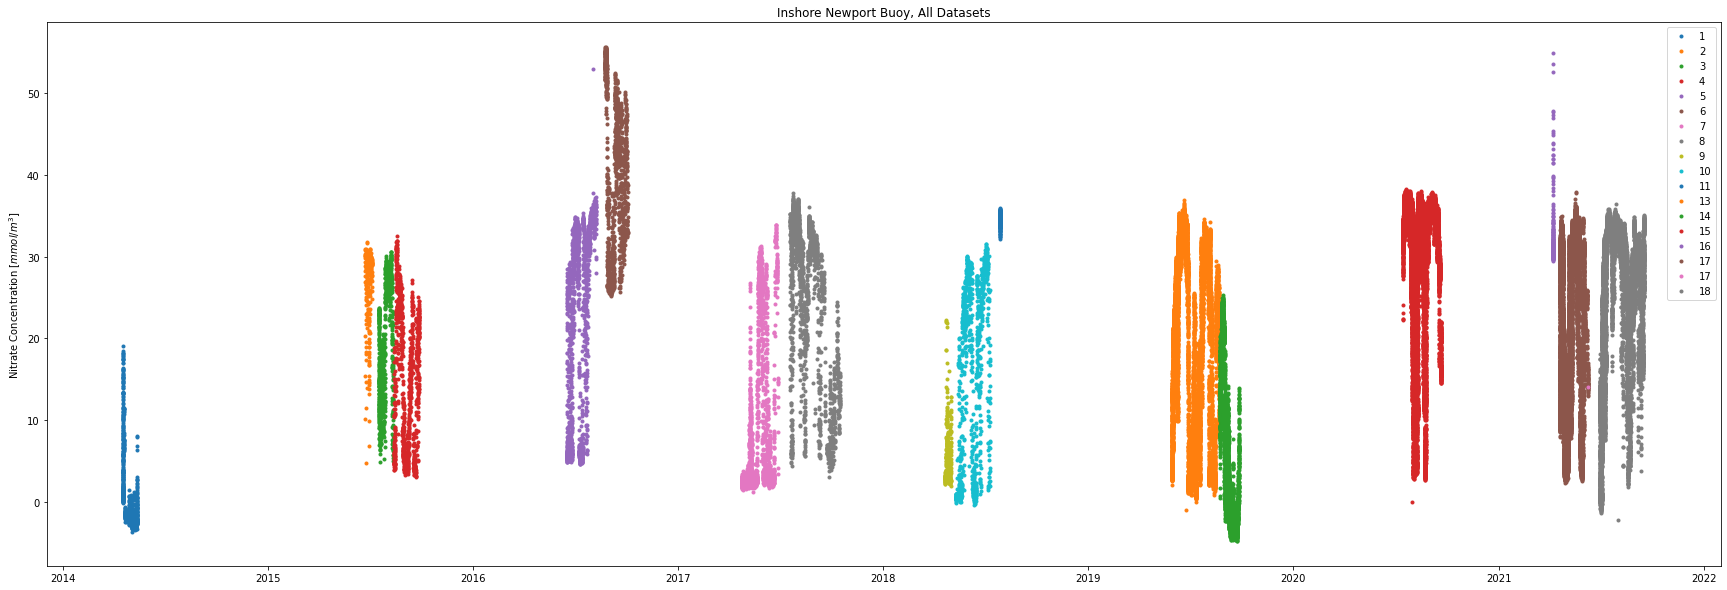

In [19]:
#plot data, in this case nitrate
fig = plt.figure(figsize=(30,10))
for i,d in enumerate(ds):
    plt.plot(d['time'][mask[i]], d['nitrate_concentration'][mask[i]], '.', label=labels[i])
plt.legend()
plt.title('Inshore Newport Buoy, All Datasets')
plt.ylabel('Nitrate Concentration [$mmol/m^3$]')

In [20]:
nda = np.nan*np.empty(len(time_grid))

for i,n in enumerate(nitrate_grid):
    nda[i] = np.nanmean(n)

C:\Users\asche\AppData\Local\Temp\ipykernel_24544\695469970.py:4: RuntimeWarning: Mean of empty slice
  nda[i] = np.nanmean(n)


In [21]:
ds_nda = xr.Dataset()
ds_nda['time'] = time_grid
ds_nda['nda'] = (['time'], nda)

(-10.0, 100.0)

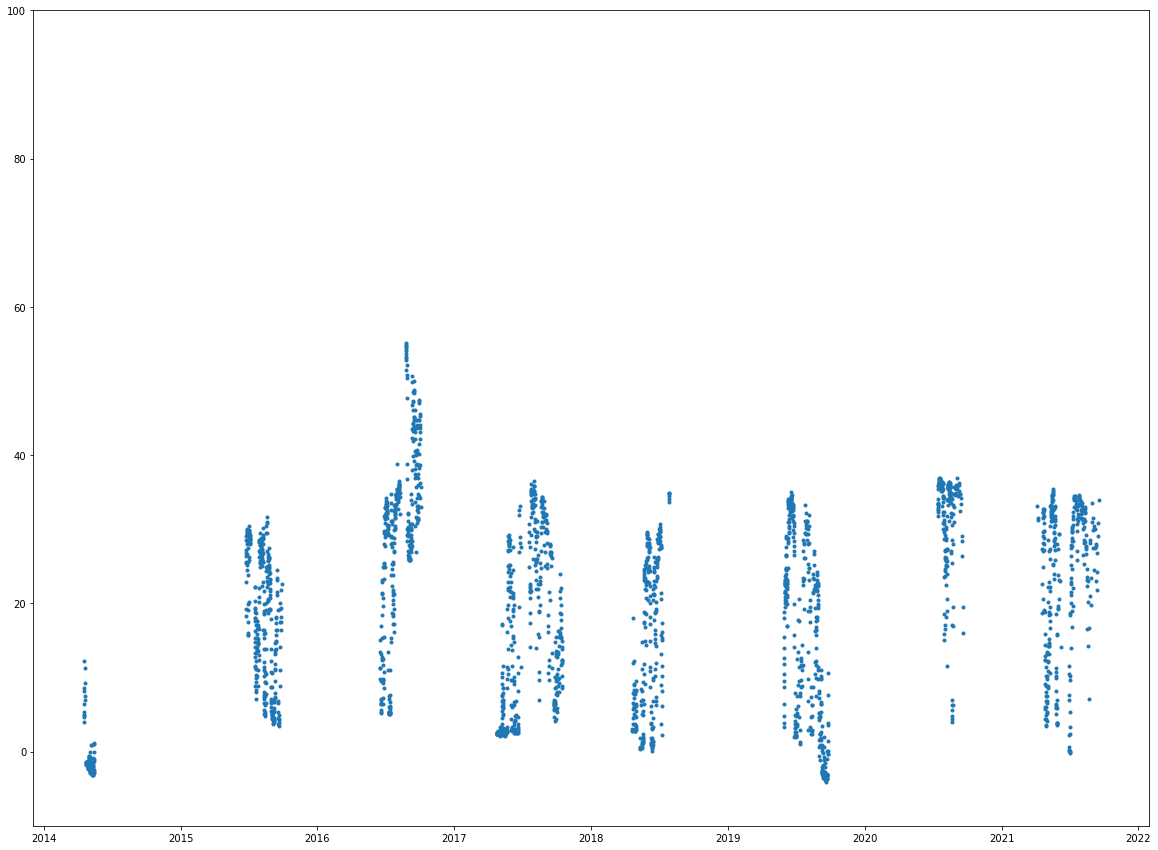

In [22]:
plt.figure(figsize=(20,15))
plt.plot(ds_nda['time'], ds_nda['nda'], '.')
plt.ylim([-10,100])
#plt.axvline(x=dep_sta[15])

In [23]:
#now let's try to sort which deployments are on that plot for the fitting....

dep_num = np.nan*np.empty(len(ds))
dep_sta = np.nan*np.empty(len(ds))
dep_end = np.nan*np.empty(len(ds))

for i,d in enumerate(ds):
    dep_num[i] = d['deployment'].values[0]
    dep_sta[i] = d['time'].values[0].astype('datetime64[ns]')
    dep_end[i] = d['time'].values[-1].astype('datetime64[ns]')
    
dep_sta = dep_sta.astype('datetime64[ns]')
dep_end = dep_end.astype('datetime64[ns]')

In [24]:
dep_num

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13., 14.,
       15., 16., 17., 17., 18.])

In [25]:
dep_sta

array(['2014-04-17T22:28:23.448999936', '2015-06-23T22:11:31.619999744',
       '2015-07-17T20:17:43.565000192', '2015-08-14T01:06:00.503000064',
       '2016-06-16T17:05:05.546999808', '2016-08-24T00:16:33.670000128',
       '2017-04-23T17:51:45.378000384', '2017-07-19T15:58:42.619999744',
       '2018-04-20T21:04:08.357999616', '2018-05-10T22:21:00.425999872',
       '2018-07-27T17:10:21.592999936', '2019-05-29T17:56:05.314999808',
       '2019-08-22T16:42:43.900000256', '2020-07-13T17:13:07.597000192',
       '2021-04-06T14:12:00.303000064', '2021-04-19T16:02:38.559000064',
       '2021-06-07T20:01:40.727999488', '2021-06-29T16:24:57.383000064'],
      dtype='datetime64[ns]')

In [26]:
dep_end

array(['2014-05-14T07:00:04.816999936', '2015-07-05T20:04:34.217999872',
       '2015-08-12T20:00:13.364999680', '2015-09-27T08:16:56.432000000',
       '2016-08-07T20:26:38.135999488', '2016-10-02T14:10:11.119000064',
       '2017-06-27T08:04:26.896000000', '2017-10-15T20:00:27.550000128',
       '2018-05-01T14:05:42.529000448', '2018-07-09T20:15:39.425999872',
       '2018-07-28T07:03:12.003000320', '2019-08-22T08:00:56.064999936',
       '2019-09-26T02:07:38.619999744', '2020-09-19T20:14:05.708000256',
       '2021-04-06T20:01:57.685999616', '2021-06-07T20:01:40.727999488',
       '2021-06-07T20:01:40.727999488', '2021-09-16T20:08:52.491000320'],
      dtype='datetime64[ns]')

In [27]:
ds_nda_resa = ds_nda.resample(time="1D", skipna=True).mean()

(0.0, 100.0)

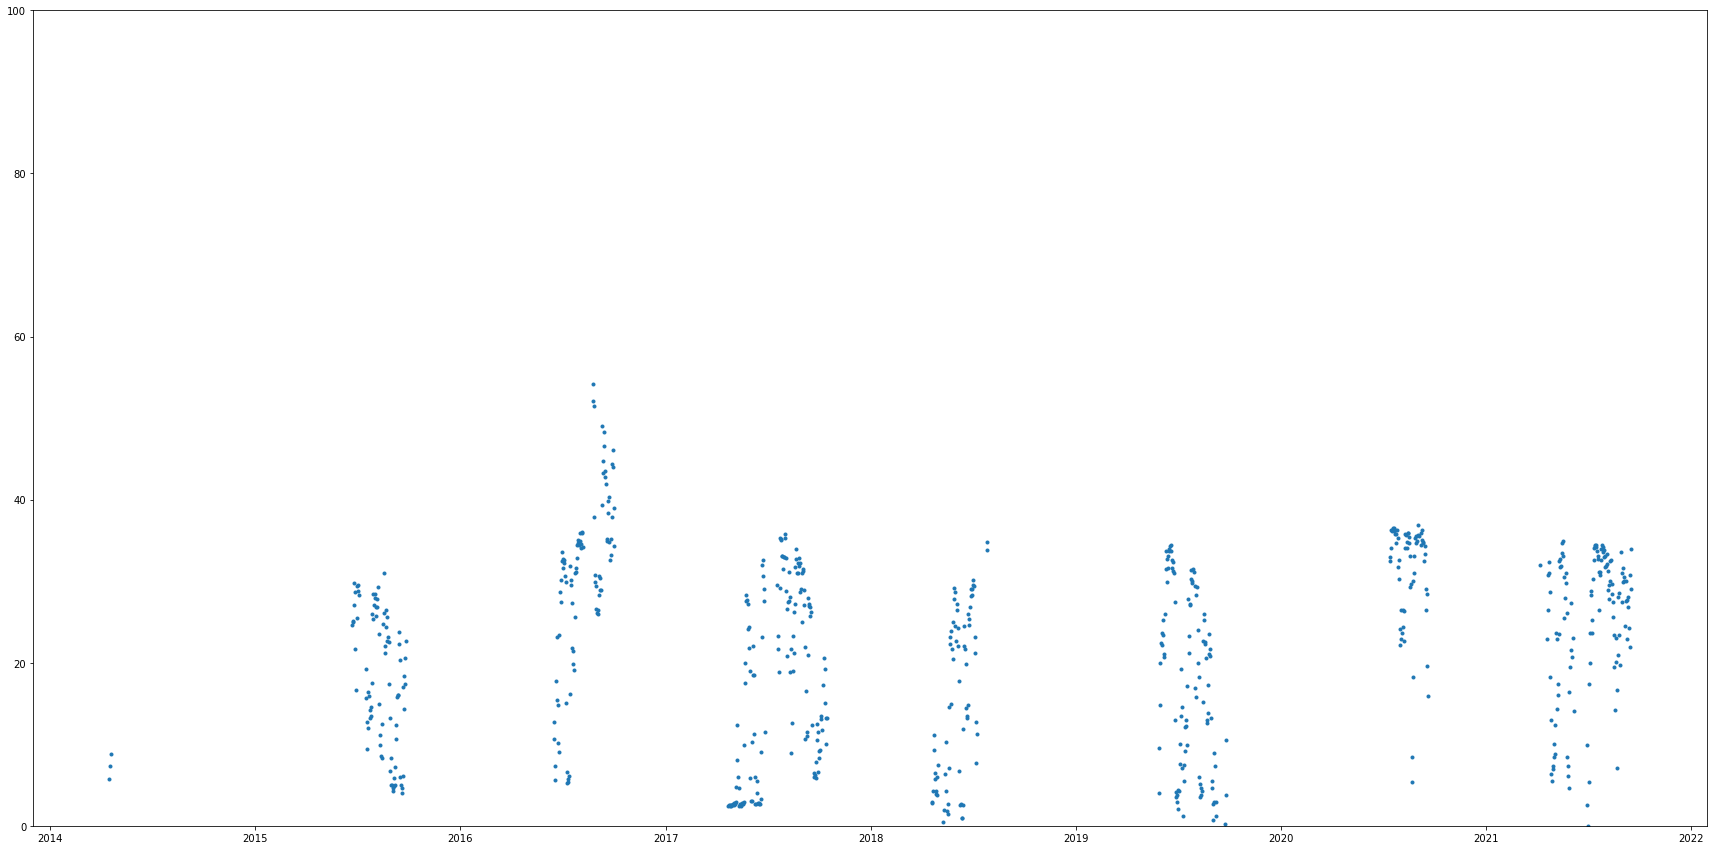

In [28]:
plt.figure(figsize=(30,15))
plt.plot(ds_nda_resa['time'], ds_nda_resa['nda'], '.')
plt.ylim([0,100])
#plt.xlim([t1,t2])

In [29]:
ds_nda_resa, ds_w_rs = xr.align(ds_nda_resa, ds_w_rs)

In [30]:
nw_mask = (~np.isnan(ds_nda_resa['nda'])) & (~np.isnan(ds_w_rs['as'])) & (ds_nda_resa['nda'] < 50) & (ds_nda_resa['nda'] >= 0)

In [31]:
#all datasets included for plotting
wind_masked = ds_w_rs['as'][nw_mask]
nda_masked = ds_nda_resa['nda'][nw_mask]
nda_time_masked = ds_nda_resa['time'][nw_mask]

In [32]:
# perform moving average (change moving average length here)
avg_len = 8
wind_mv = moving_average(wind_masked, avg_len)

In [33]:
good_mask = nw_mask & ((ds_nda_resa['time'] < dep_sta[5]) | (ds_nda_resa['time'] > dep_end[5]))

In [34]:
#good data for fitting
wind_masked_g = ds_w_rs['as'][good_mask]
nda_masked_g = ds_nda_resa['nda'][good_mask]
nda_time_masked_g = ds_nda_resa['time'][good_mask]
wind_mv_g = moving_average(wind_masked_g, avg_len)

In [35]:
bad_mask = nw_mask & ((ds_nda_resa['time'] > dep_sta[5]) & (ds_nda_resa['time'] < dep_end[5]))

In [36]:
#bad data for display only (deployment 15)
wind_masked_b = ds_w_rs['as'][bad_mask]
nda_masked_b = ds_nda_resa['nda'][bad_mask]
nda_time_masked_b = ds_nda_resa['time'][bad_mask]
wind_mv_b = moving_average(wind_masked_b, avg_len)

Text(0, 0.5, 'Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

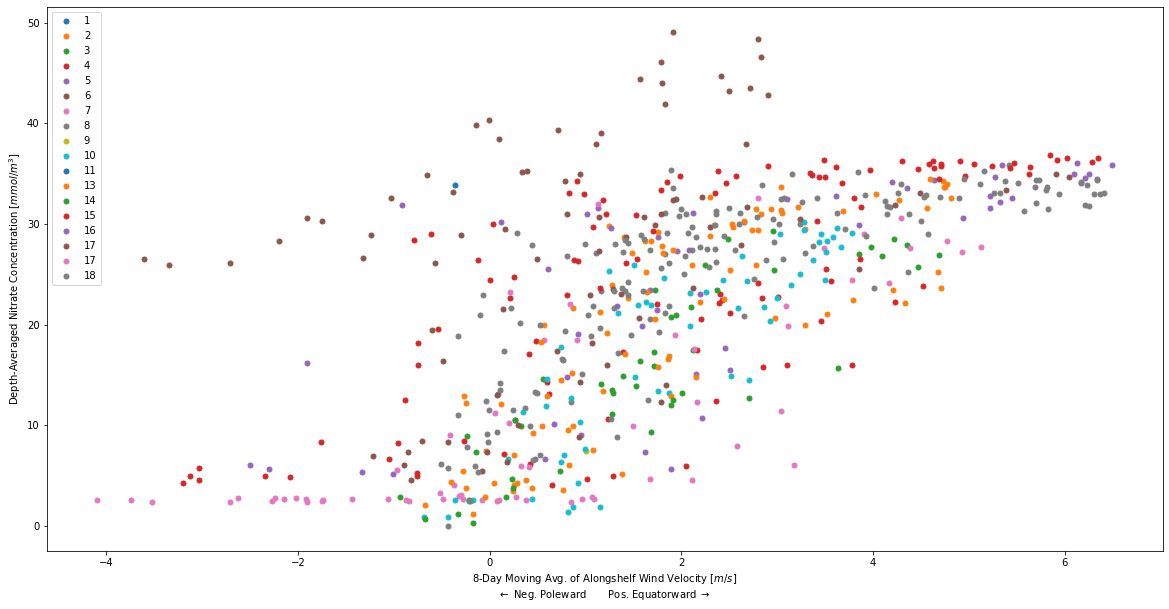

In [37]:
plt.figure(figsize=(20,10))
for t1,t2,dep in zip(dep_sta, dep_end, dep_num):
    mask_time = (nda_time_masked[avg_len-1:] > t1) & (nda_time_masked[avg_len-1:] < t2)
    plt.plot(-wind_mv[mask_time], nda_masked[avg_len-1:][mask_time], '.', markersize=10, label=int(dep))
plt.legend()
plt.xlabel('8-Day Moving Avg. of Alongshelf Wind Velocity [$m/s$]\n$\\leftarrow$ Neg. Poleward \t Pos. Equatorward $\\rightarrow$')
plt.ylabel('Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

In [38]:
avg_len = 8
wind_mv_g = moving_average(wind_masked_g, avg_len)

In [39]:
fit,cov_mat = cs(logistic, -wind_mv_g, nda_masked_g[avg_len-1:], p0=[1,40,5])

In [40]:
fit

array([ 0.6602142 , 34.86720811, -0.71008333])

In [41]:
nda_masked_lgs = logistic(np.sort(-wind_mv_g),fit[0],fit[1],fit[2])

In [42]:
cov_mat

array([[ 3.16990009e-03, -5.33525022e-02, -9.89417078e-05],
       [-5.33525022e-02,  1.43314143e+00, -3.91410823e-02],
       [-9.89417078e-05, -3.91410823e-02,  4.81155571e-03]])

In [43]:
covariance = np.corrcoef(np.sort(nda_masked_g[avg_len-1:]), np.sort(nda_masked_lgs))

In [44]:
covariance[1][0]**2 # don't think I'm doing correlation correctly - review!

0.9774222001308722

Text(0, 0.5, 'Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

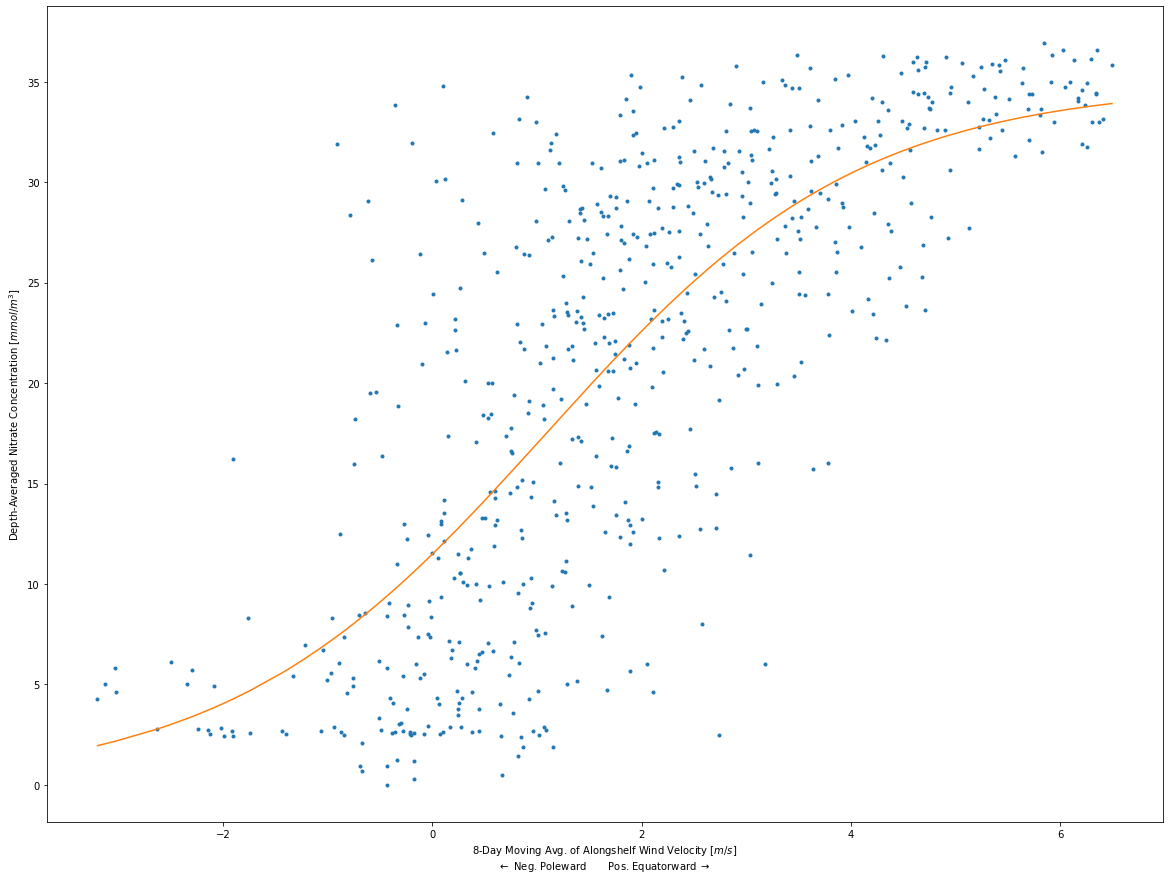

In [45]:
plt.figure(figsize=(20,15))
plt.plot(-wind_mv_g, nda_masked_g[avg_len-1:] ,'.')
plt.plot(np.sort(-wind_mv_g), nda_masked_lgs) 
#plt.plot(-wind_mv_b, nda_masked_b[avg_len-1:], '.',  color='r')
#plt.ylim([0,50])
plt.xlabel('8-Day Moving Avg. of Alongshelf Wind Velocity [$m/s$]\n$\\leftarrow$ Neg. Poleward \t Pos. Equatorward $\\rightarrow$')
plt.ylabel('Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

Text(0, 0.5, 'Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

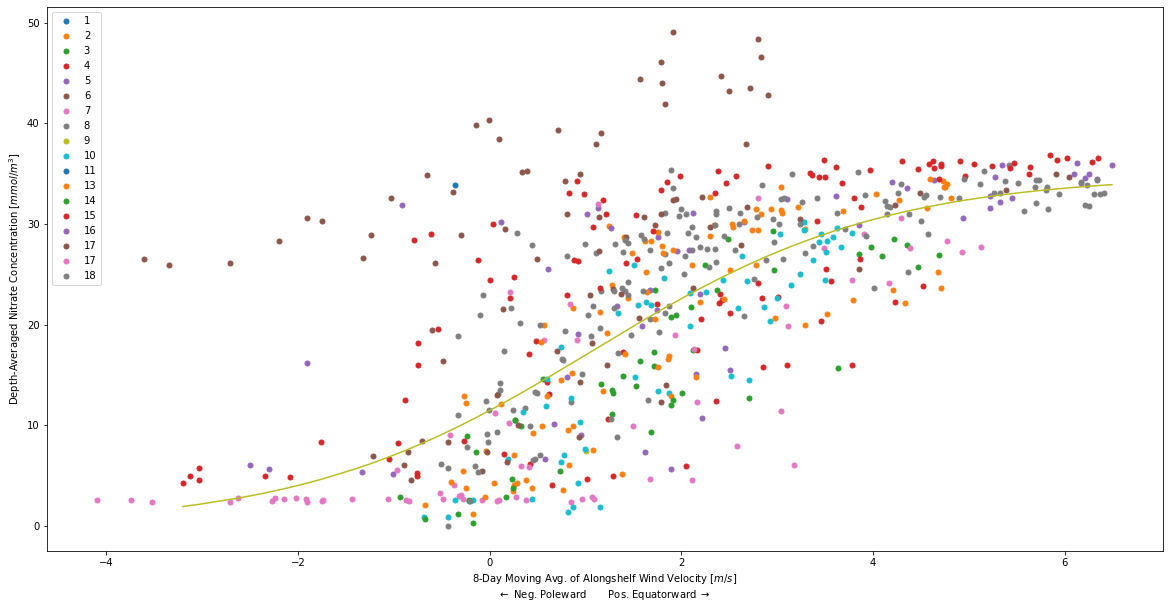

In [46]:
plt.figure(figsize=(20,10))
for t1,t2,dep in zip(dep_sta, dep_end, dep_num):
    mask_time = (nda_time_masked[avg_len-1:] > t1) & (nda_time_masked[avg_len-1:] < t2)
    plt.plot(-wind_mv[mask_time], nda_masked[avg_len-1:][mask_time], '.', markersize=10, label=int(dep))
plt.plot(np.sort(-wind_mv_g), nda_masked_lgs) 
plt.legend()
plt.xlabel('8-Day Moving Avg. of Alongshelf Wind Velocity [$m/s$]\n$\\leftarrow$ Neg. Poleward \t Pos. Equatorward $\\rightarrow$')
plt.ylabel('Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

In [47]:
st.linregress(-wind_mv, nda_masked[avg_len-1:])

LinregressResult(slope=3.6194445621537596, intercept=15.16665704506871, rvalue=0.6510819474192796, pvalue=3.967802585968508e-83, stderr=0.16216531698766007, intercept_stderr=0.4432995290107637)

In [48]:
#repeating above process for non-rotated, raw wind data

nw_mask = (~np.isnan(ds_nda_resa['nda'])) & (~np.isnan(ds_w_rs['wind_north'])) & (ds_nda_resa['nda'] < 50) & (ds_nda_resa['nda'] >= 0)

In [49]:
#all datasets included for plotting
wind_masked = ds_w_rs['wind_north'][nw_mask]
nda_masked = ds_nda_resa['nda'][nw_mask]
nda_time_masked = ds_nda_resa['time'][nw_mask]

In [50]:
# perform moving average (change moving average length here)
avg_len = 8
wind_mv = moving_average(wind_masked, avg_len)

In [51]:
good_mask = nw_mask & ((ds_nda_resa['time'] < dep_sta[5]) | (ds_nda_resa['time'] > dep_end[5]))

In [52]:
#good data for fitting
wind_masked_g = ds_w_rs['wind_north'][good_mask]
nda_masked_g = ds_nda_resa['nda'][good_mask]
nda_time_masked_g = ds_nda_resa['time'][good_mask]
wind_mv_g = moving_average(wind_masked_g, avg_len)

In [53]:
bad_mask = nw_mask & ((ds_nda_resa['time'] > dep_sta[5]) & (ds_nda_resa['time'] < dep_end[5]))

In [54]:
#bad data for display only (deployment 15)
wind_masked_b = ds_w_rs['wind_north'][bad_mask]
nda_masked_b = ds_nda_resa['nda'][bad_mask]
nda_time_masked_b = ds_nda_resa['time'][bad_mask]
wind_mv_b = moving_average(wind_masked_b, avg_len)

Text(0, 0.5, 'Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

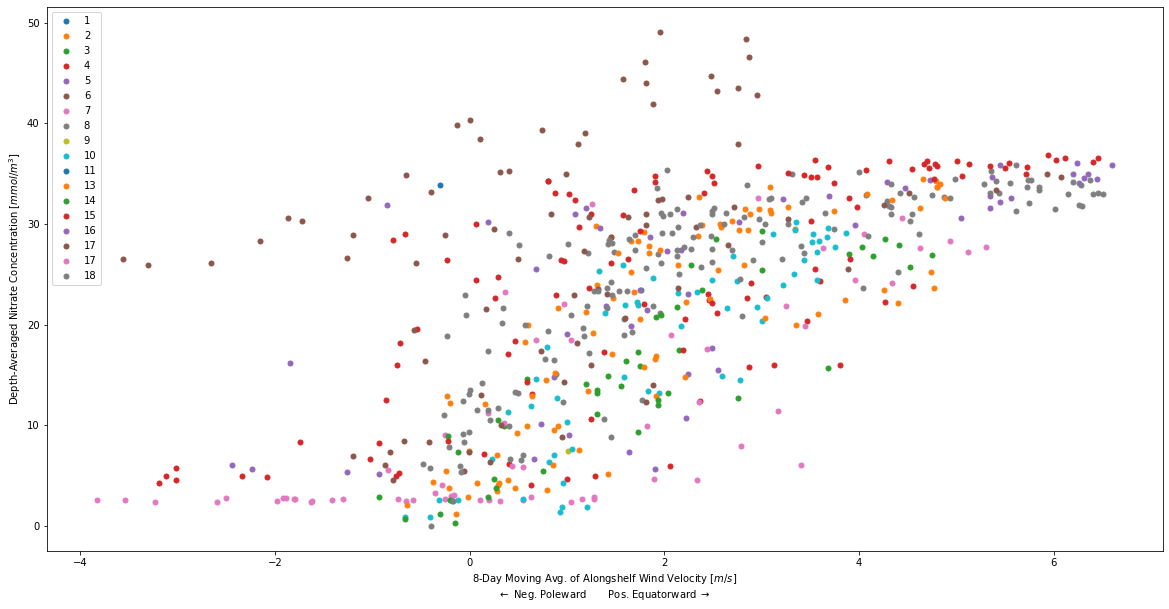

In [55]:
cdict = cm.tools.get_dict(mpcm.jet, N=len(dep_num))
colormap = LinearSegmentedColormap('cmap', cdict)
plt.figure(figsize=(20,10))
for t1,t2,dep in zip(dep_sta, dep_end, dep_num):
    mask_time = (nda_time_masked[avg_len-1:] > t1) & (nda_time_masked[avg_len-1:] < t2)
    plt.plot(-wind_mv[mask_time], nda_masked[avg_len-1:][mask_time], '.', markersize=10, label=int(dep))
plt.legend()
plt.xlabel('8-Day Moving Avg. of Alongshelf Wind Velocity [$m/s$]\n$\\leftarrow$ Neg. Poleward \t Pos. Equatorward $\\rightarrow$')
plt.ylabel('Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

In [56]:
avg_len = 8
wind_mv_g = moving_average(wind_masked_g, avg_len)

In [57]:
fit,cov_mat = cs(logistic, -wind_mv_g, nda_masked_g[avg_len-1:], p0=[1,40,5])

In [58]:
fit

array([ 0.65026607, 34.87959414, -0.73409261])

In [59]:
nda_masked_lgs = logistic(np.sort(-wind_mv_g),fit[0],fit[1],fit[2])

In [60]:
cov_mat

array([[ 3.16067145e-03, -5.43903539e-02, -1.87753304e-04],
       [-5.43903539e-02,  1.48501384e+00, -3.85085840e-02],
       [-1.87753304e-04, -3.85085840e-02,  4.89848965e-03]])

In [61]:
covariance = np.corrcoef(np.sort(nda_masked_g[avg_len-1:]), np.sort(nda_masked_lgs))

In [62]:
covariance[1][0]**2 # don't think I'm doing correlation correctly - review!

0.9770903169653671

Text(0, 0.5, 'Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

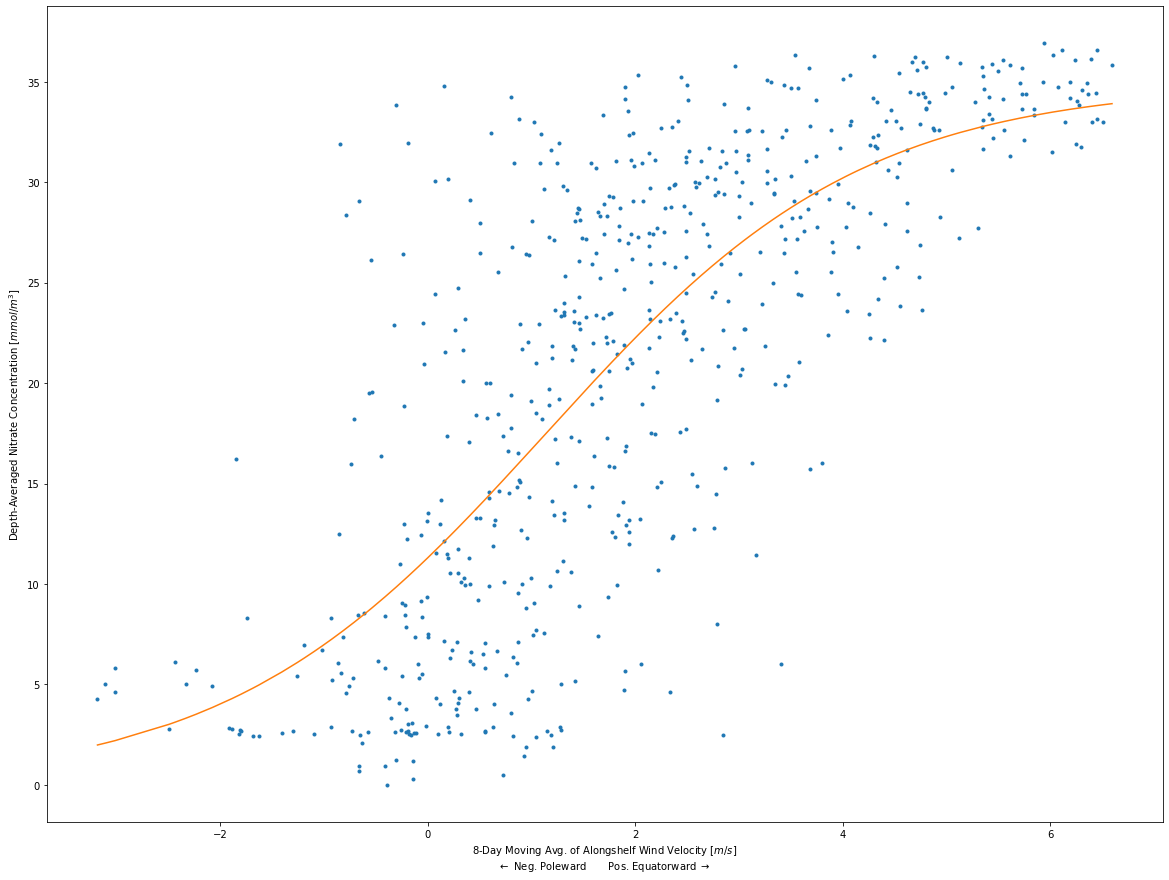

In [63]:
plt.figure(figsize=(20,15))
plt.plot(-wind_mv_g, nda_masked_g[avg_len-1:] ,'.')
plt.plot(np.sort(-wind_mv_g), nda_masked_lgs) 
#plt.plot(-wind_mv_b, nda_masked_b[avg_len-1:], '.',  color='r')
#plt.ylim([0,50])
plt.xlabel('8-Day Moving Avg. of Alongshelf Wind Velocity [$m/s$]\n$\\leftarrow$ Neg. Poleward \t Pos. Equatorward $\\rightarrow$')
plt.ylabel('Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

Text(0, 0.5, 'Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

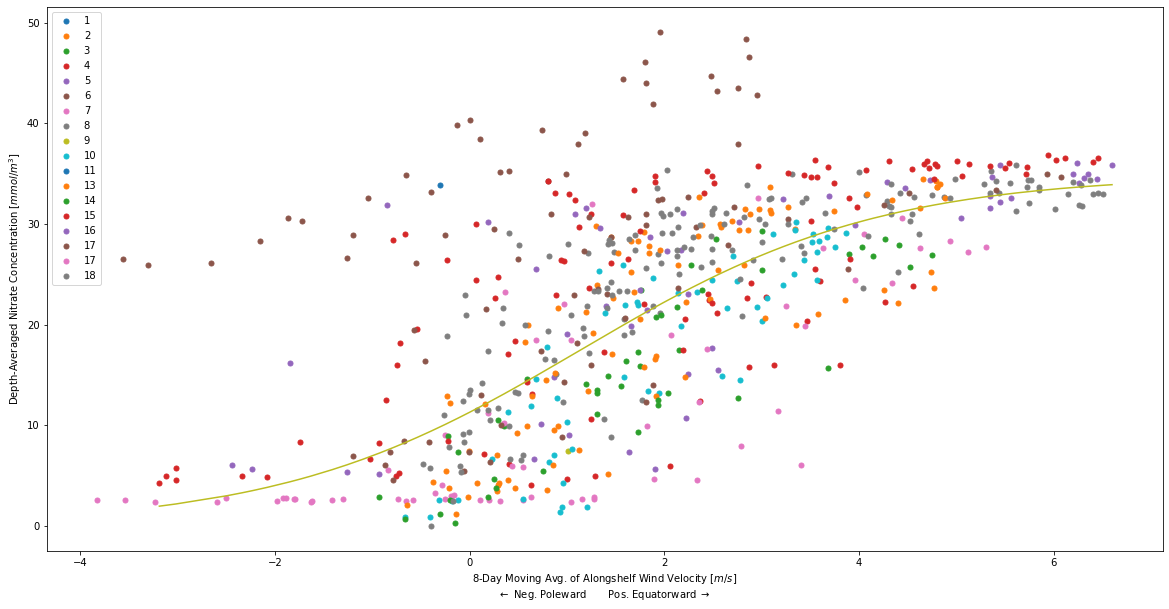

In [64]:
plt.figure(figsize=(20,10))
for t1,t2,dep in zip(dep_sta, dep_end, dep_num):
    mask_time = (nda_time_masked[avg_len-1:] > t1) & (nda_time_masked[avg_len-1:] < t2)
    plt.plot(-wind_mv[mask_time], nda_masked[avg_len-1:][mask_time], '.', markersize=10, label=int(dep))
plt.plot(np.sort(-wind_mv_g), nda_masked_lgs) 
plt.legend()
plt.xlabel('8-Day Moving Avg. of Alongshelf Wind Velocity [$m/s$]\n$\\leftarrow$ Neg. Poleward \t Pos. Equatorward $\\rightarrow$')
plt.ylabel('Depth-Averaged Nitrate Concentration [$mmol/m^3$]')

# Quality Control & Ship Data Comparisons

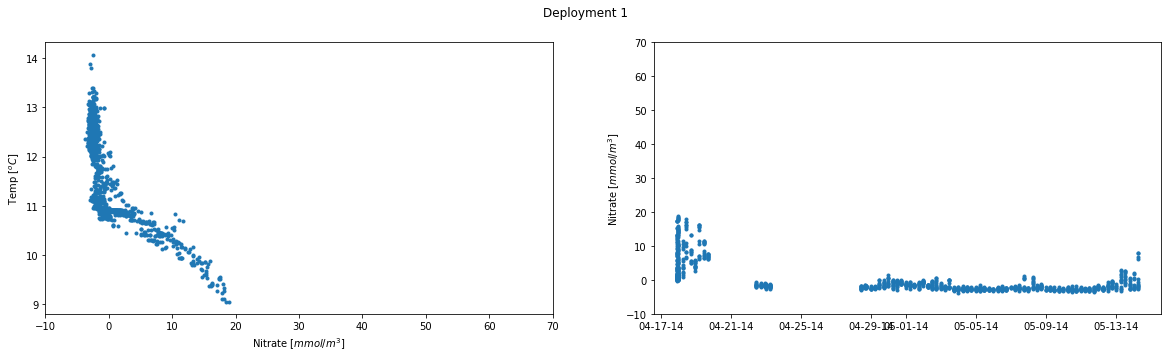

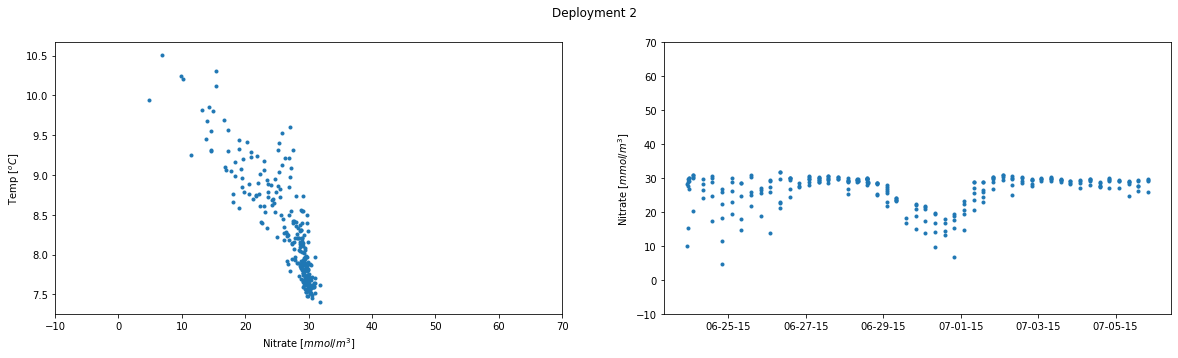

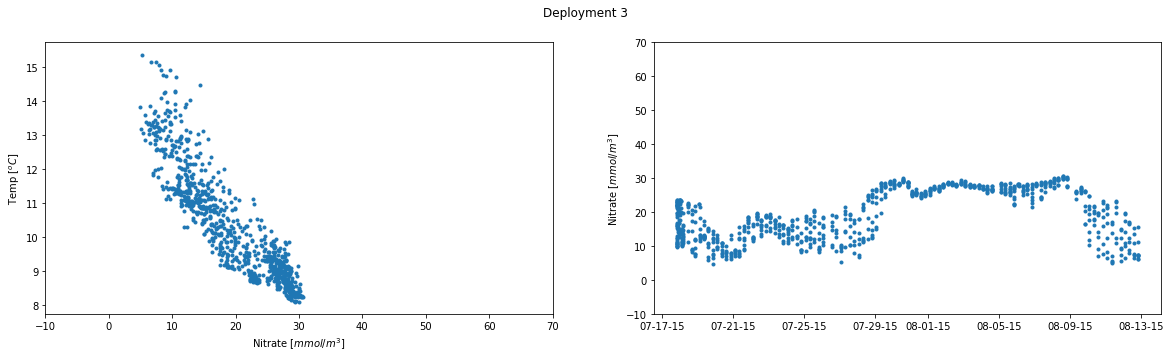

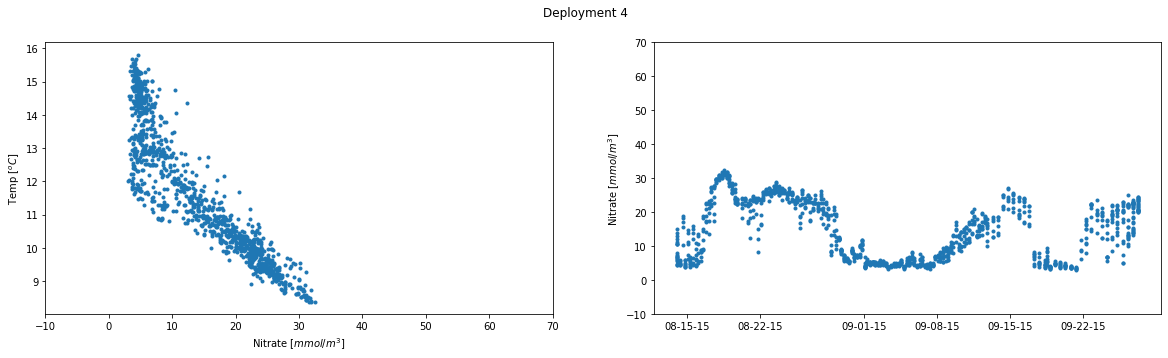

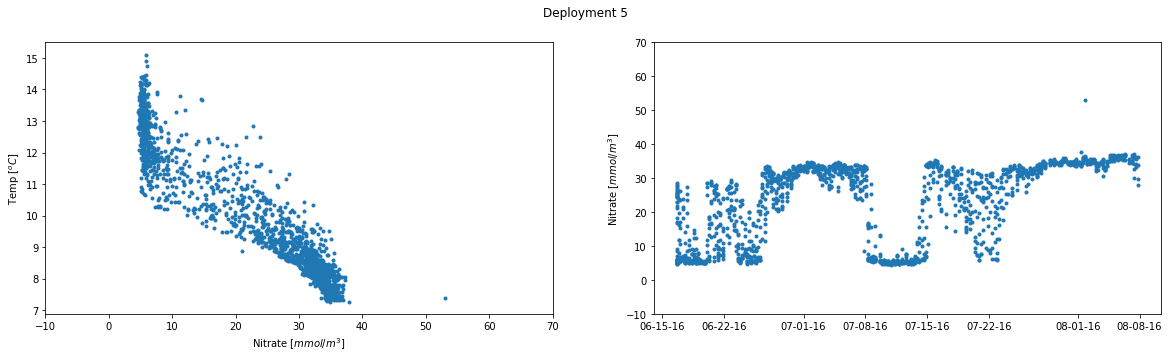

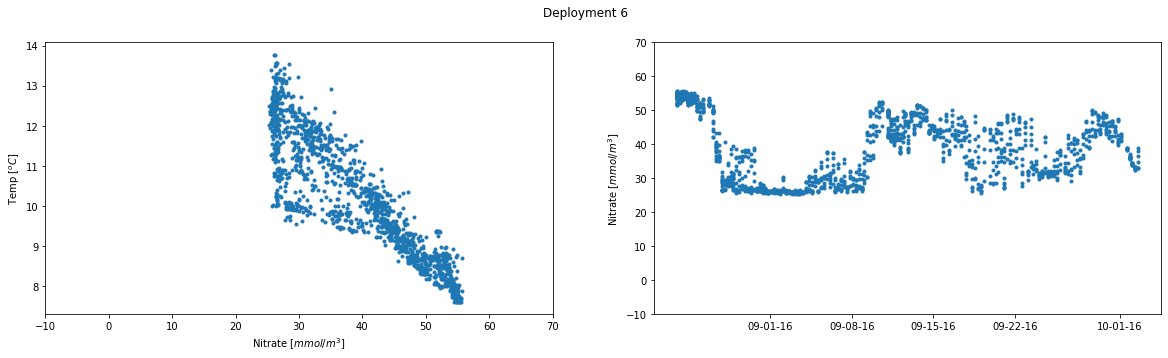

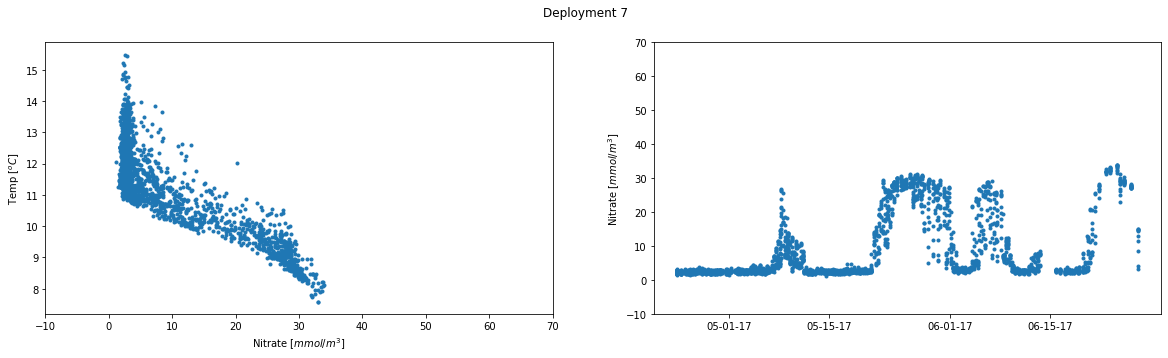

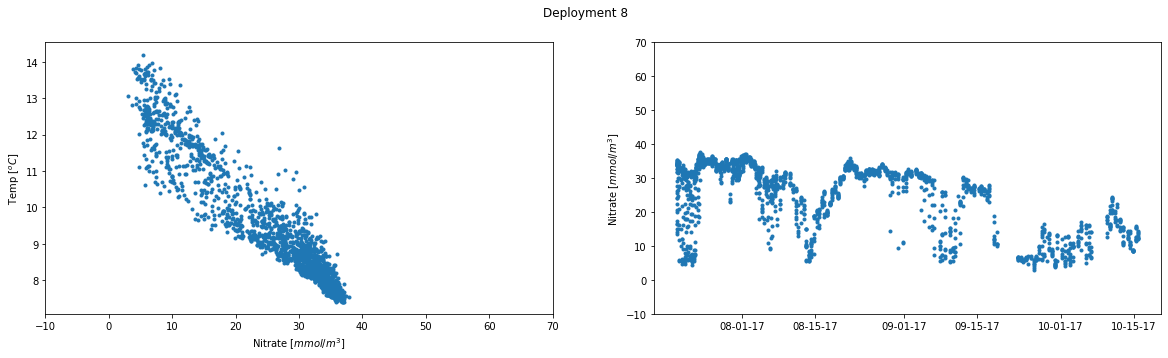

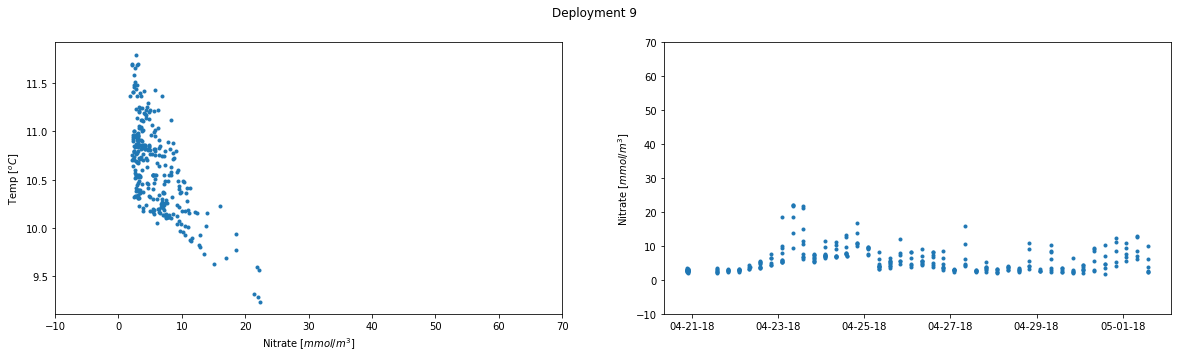

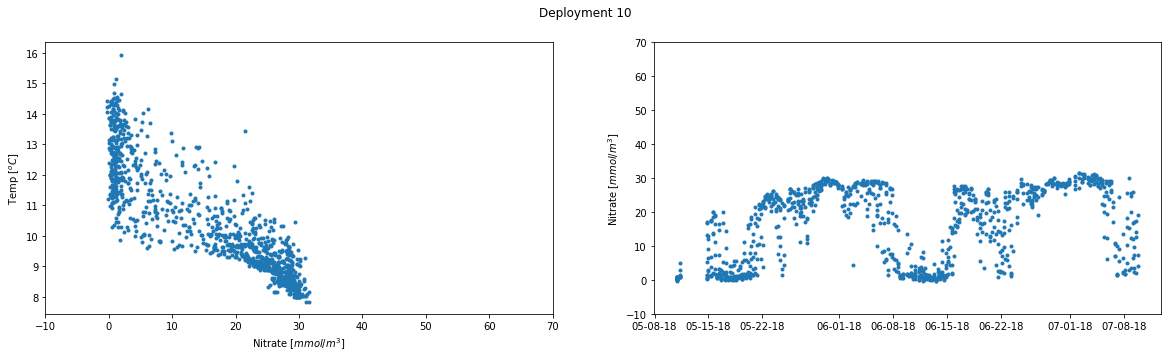

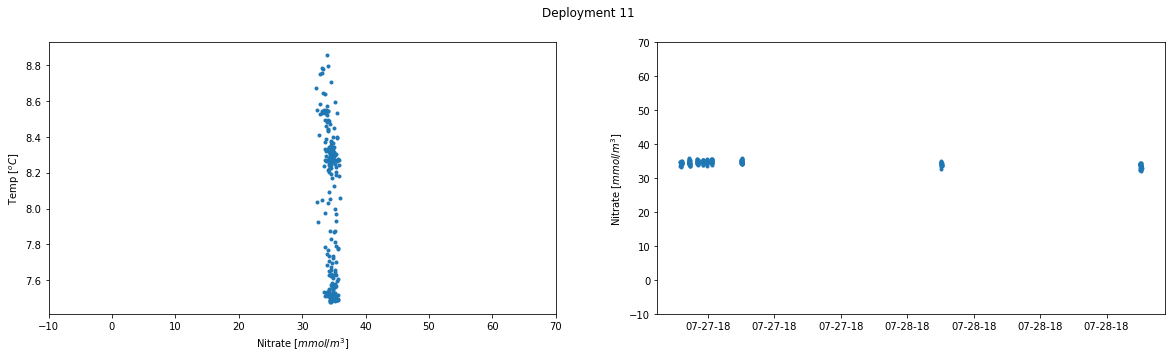

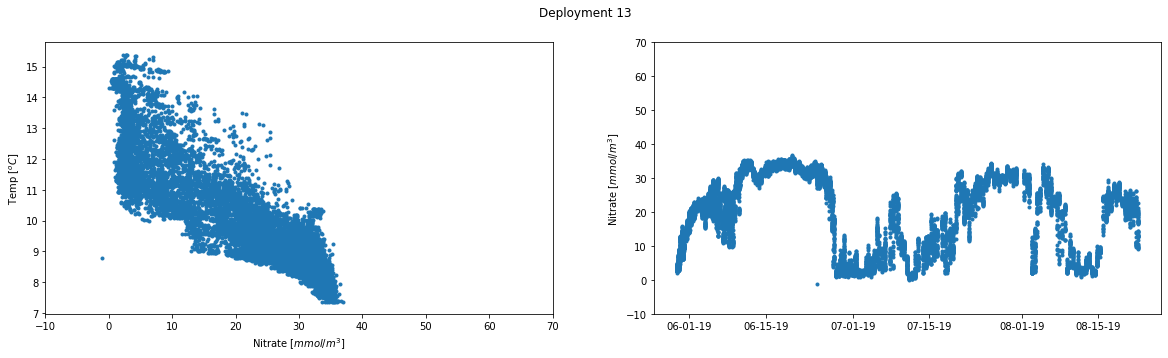

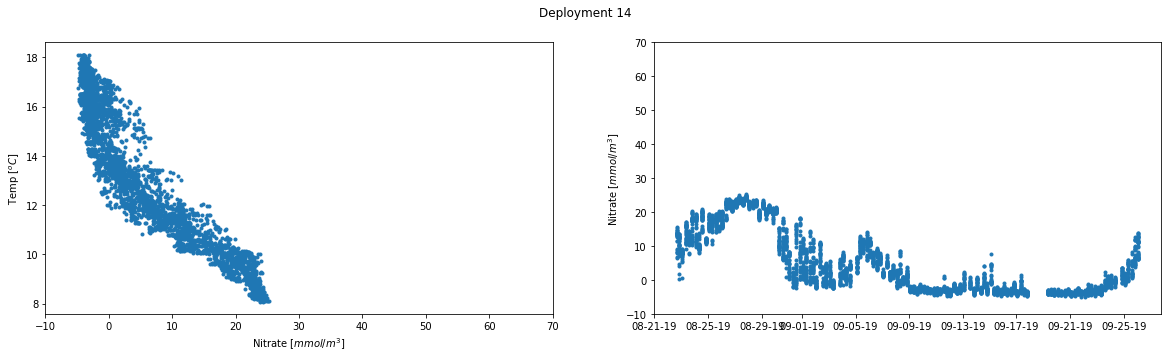

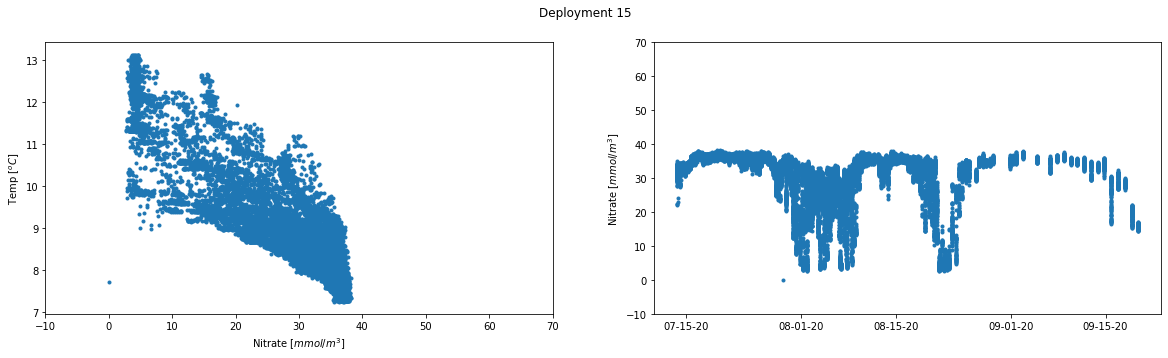

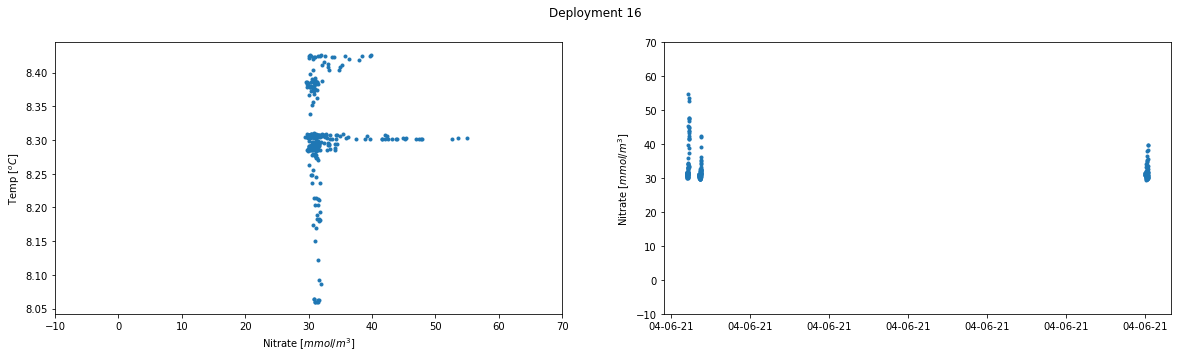

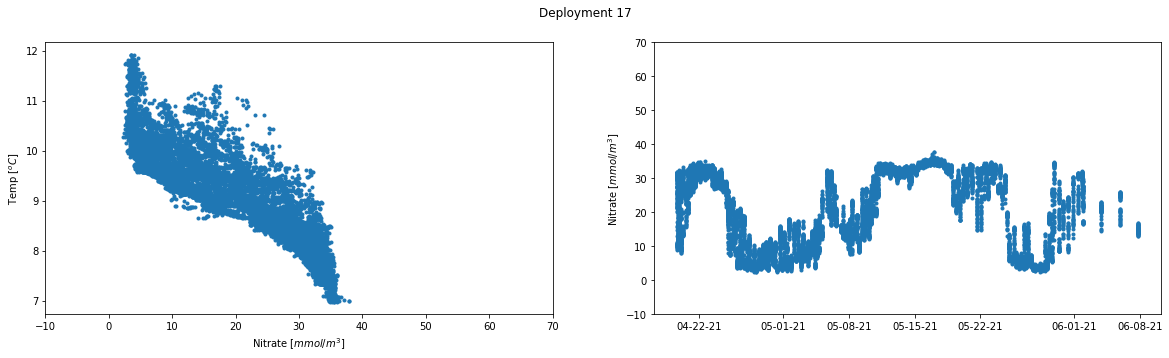

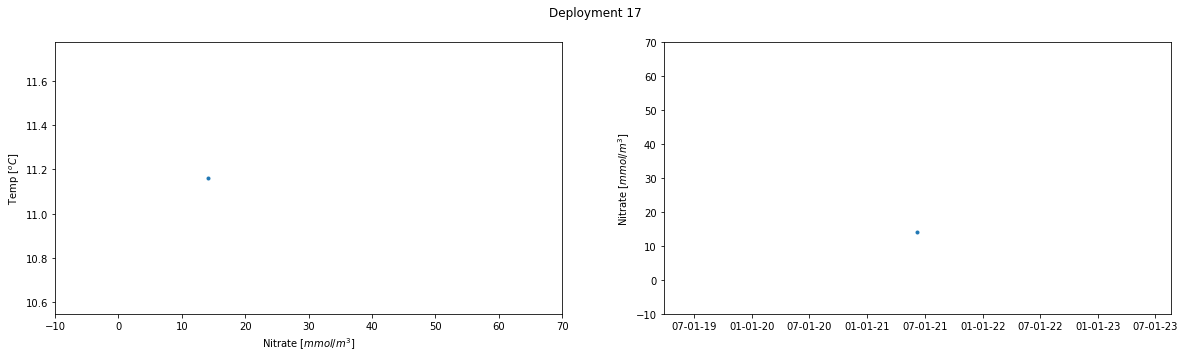

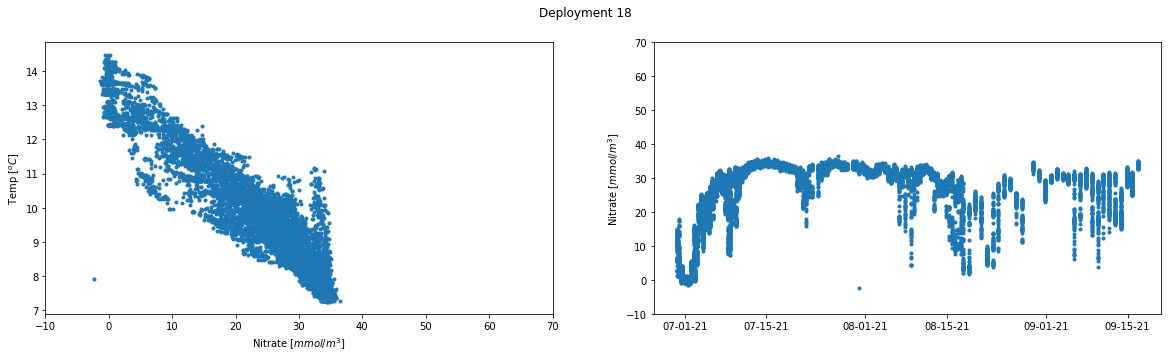

In [65]:
myFmt = DateFormatter("%m-%d-%y")

for i,d in enumerate(ds):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    ax1.plot(d['nitrate_concentration'], d['temperature'],'.')
    ax2.plot(d['time'], d['nitrate_concentration'], '.')
    fig.suptitle('Deployment %i' %(d['deployment'].values[0]))
    ax1.set_xlabel('Nitrate [$mmol/m^3]$')
    ax1.set_ylabel('Temp [$^oC]$')
    ax2.set_ylabel('Nitrate [$mmol/m^3]$')
    ax1.set_xlim([-10,70])
    ax2.set_ylim([-10,70])
    ax2.xaxis.set_major_formatter(myFmt)
    #ax2.set_xlim([dep_sta[0],dep_end[-1]])

In [66]:
readpath = 'C:/Users/asche/REU21/completeshipdata'
fileList = os.listdir(readpath)

In [67]:
df_list = []
col_names = ['Station', 'Start Time [UTC]', 'CTD Temperature 1 [deg C]', 'CTD Temperature 2 [deg C]', 'Discrete Nitrate [uM]']
for f in fileList:
    df_temp = pd.read_csv(os.path.join(readpath,f), usecols = col_names)
    rows = df_temp.loc[df_temp['Station']=='CE01']
    df_list.append(rows)
    
df = pd.concat(df_list)
df = df.rename(columns={'Start Time [UTC]':'Time', 'CTD Temperature 1 [deg C]':'Temp1', 'CTD Temperature 2 [deg C]':'Temp2', 'Discrete Nitrate [uM]':'Nitrate'})
df['Time'] = pd.to_datetime(df['Time'])

In [68]:
df

,Station,Time,Temp1,Temp2,Nitrate
0,CE01,2014-04-17 18:42:34+00:00,8.8510,8.7892,2.242190e+01
1,CE01,2014-04-17 18:42:34+00:00,8.8510,8.7892,2.257880e+01
2,CE01,2014-04-17 18:42:34+00:00,10.2325,10.2719,1.139260e+01
3,CE01,2014-04-17 18:42:34+00:00,10.2325,10.2719,1.156200e+01
4,CE01,2014-04-17 18:42:34+00:00,10.4299,10.5382,7.444300e+00
...,...,...,...,...,...
87,CE01,2021-09-22 19:14:20+00:00,11.3891,11.3735,-9.999999e+06
88,CE01,2021-09-22 19:14:20+00:00,11.4548,11.3870,-9.999999e+06
89,CE01,2021-09-22 19:14:20+00:00,11.4548,11.3870,-9.999999e+06
90,CE01,2021-09-22 19:14:20+00:00,11.6096,11.6105,-9.999999e+06


In [69]:
ship_mask = ((df['Temp1'] >= 0) & (df['Temp2'] >= 0) & (df['Nitrate'] >= 0))

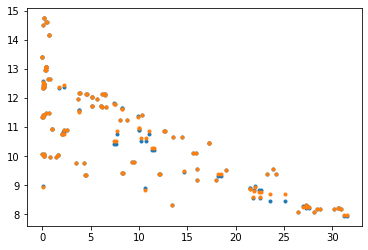

In [70]:
plt.plot(df['Nitrate'][ship_mask], df['Temp1'][ship_mask], '.')
plt.plot(df['Nitrate'][ship_mask], df['Temp2'][ship_mask], '.')

In [71]:
print(type(df['Time'][0]))
print(type(ds[0]['time'].values[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.datetime64'>


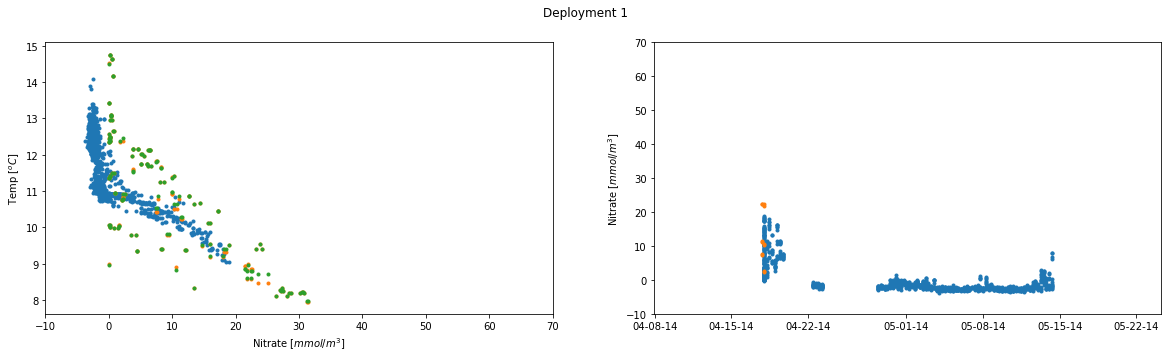

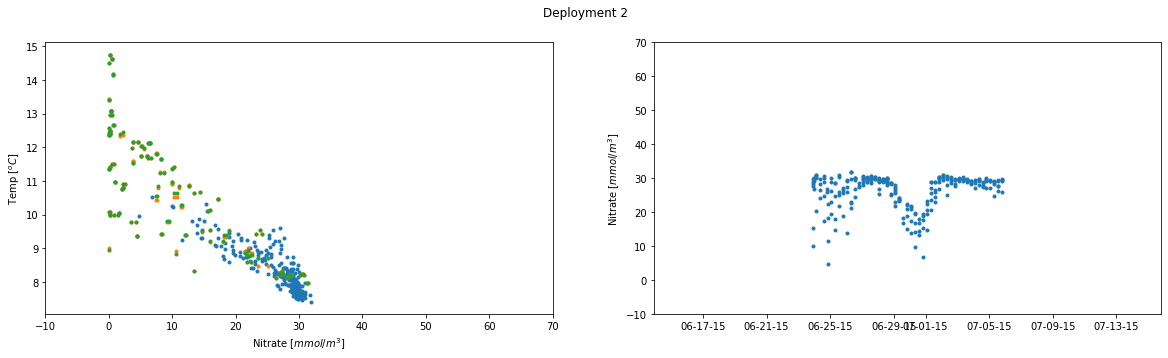

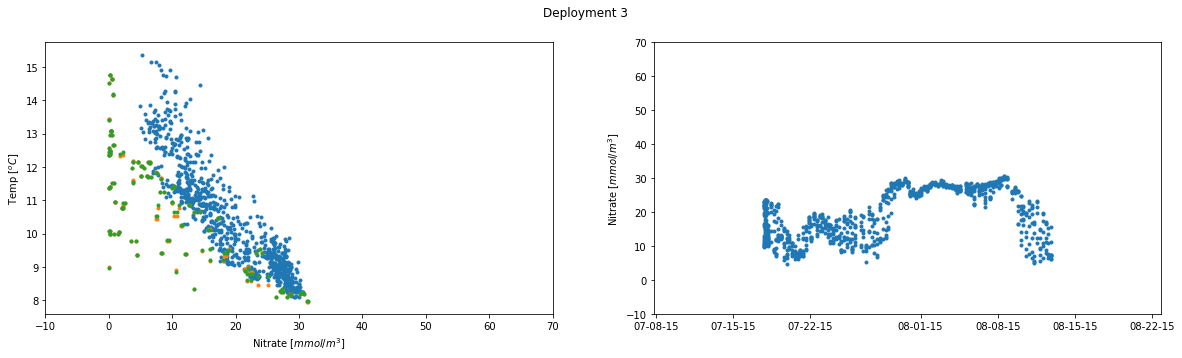

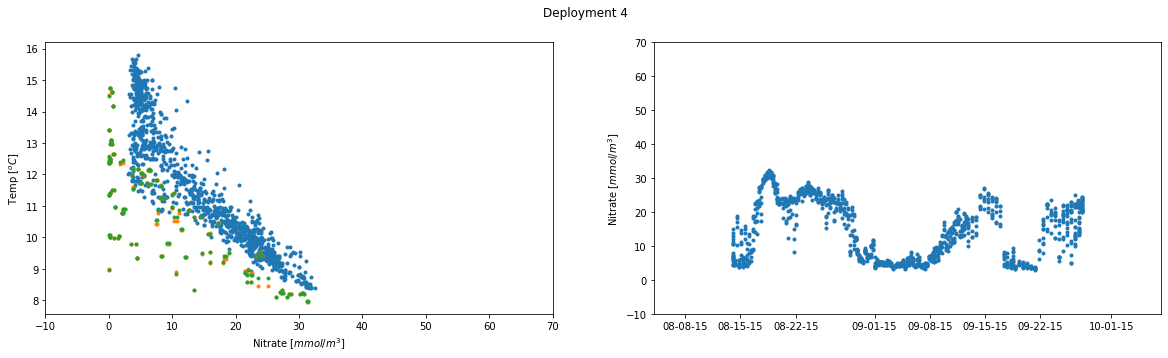

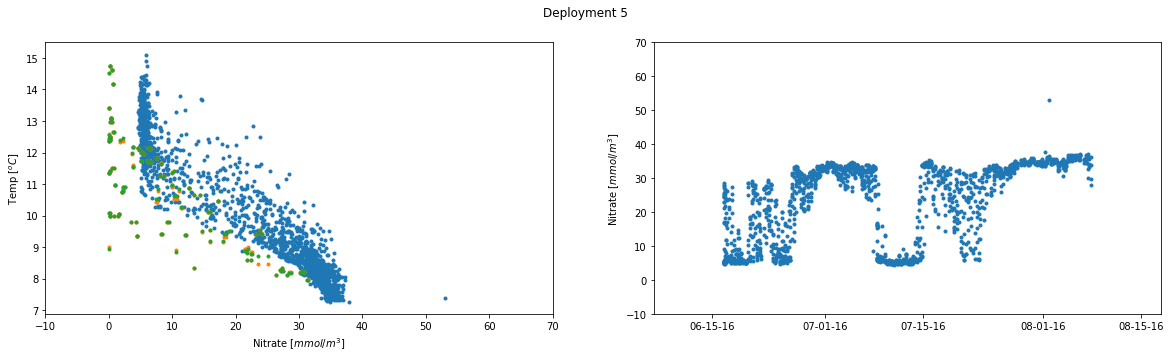

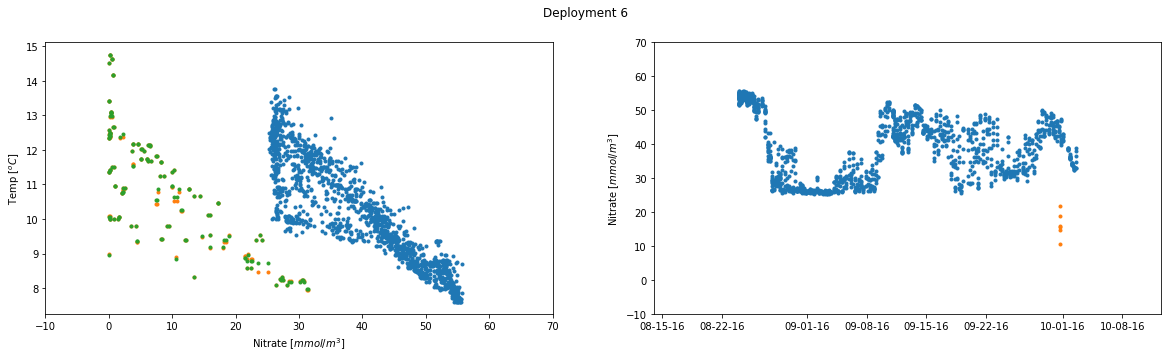

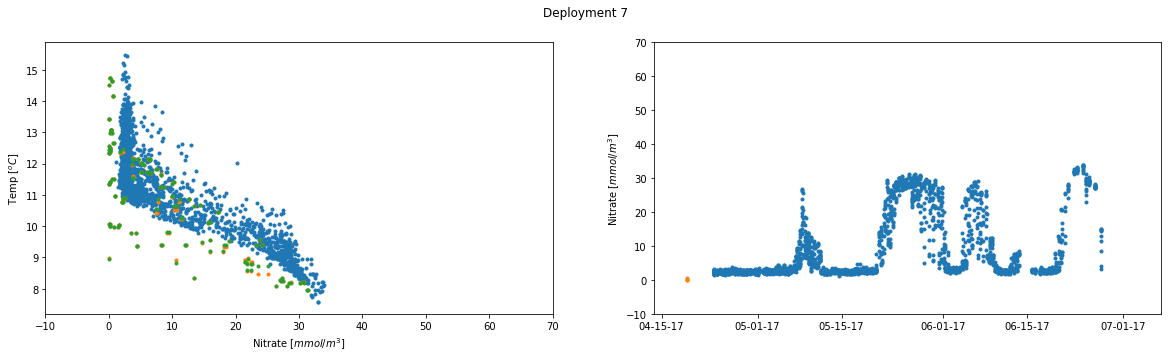

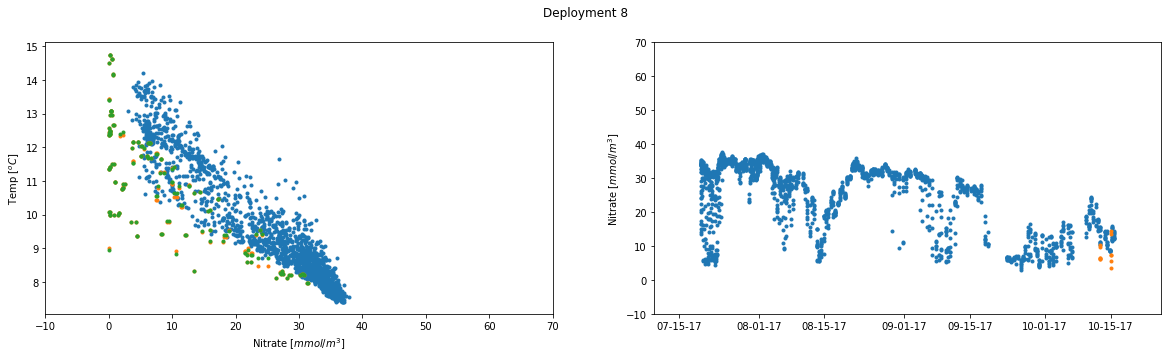

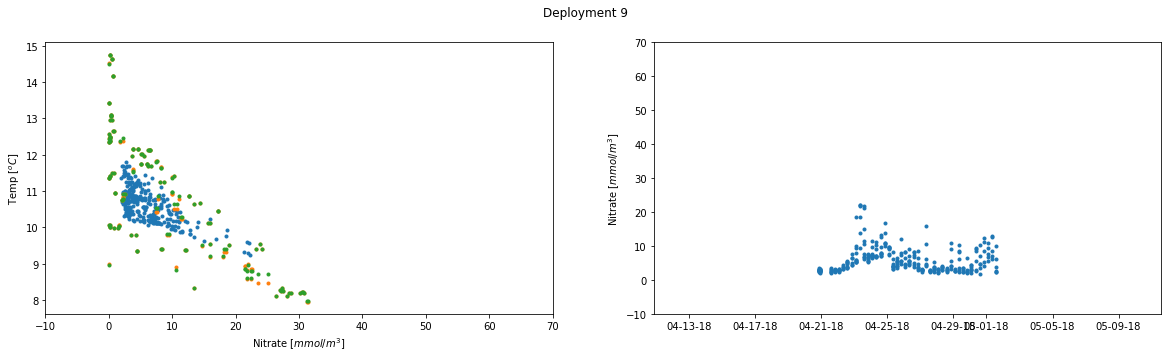

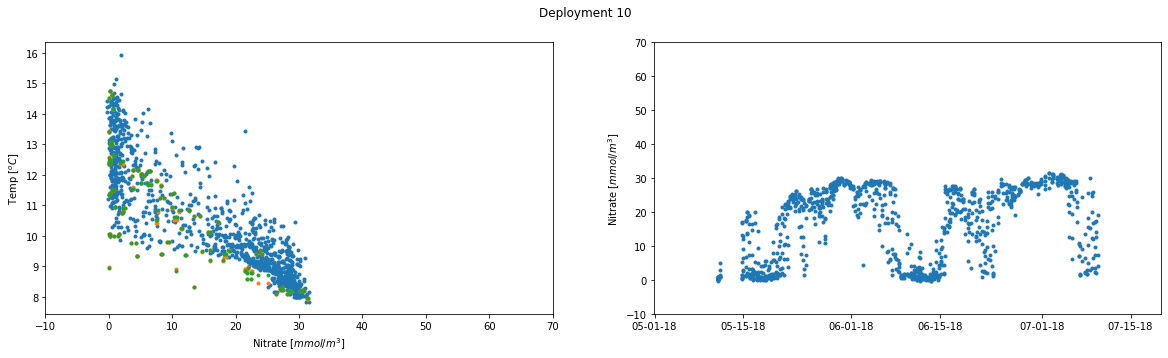

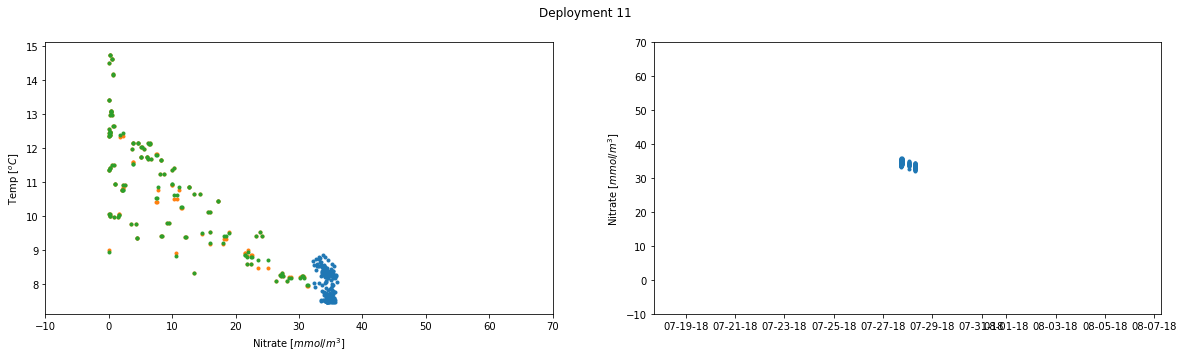

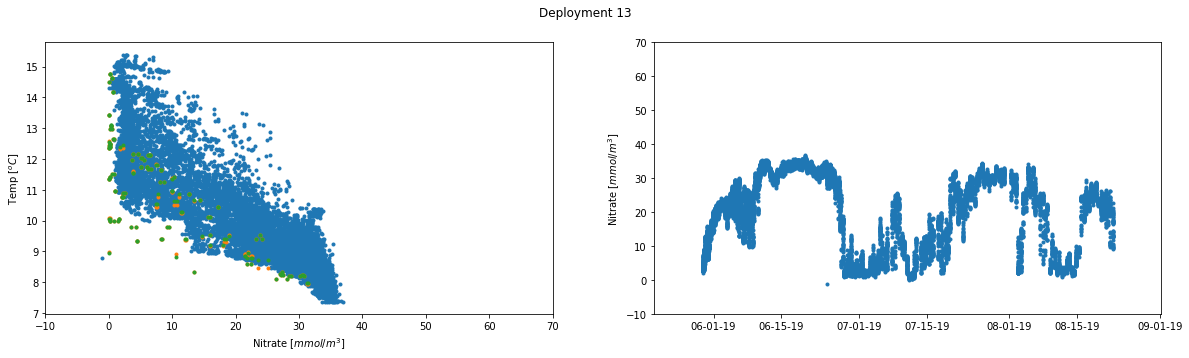

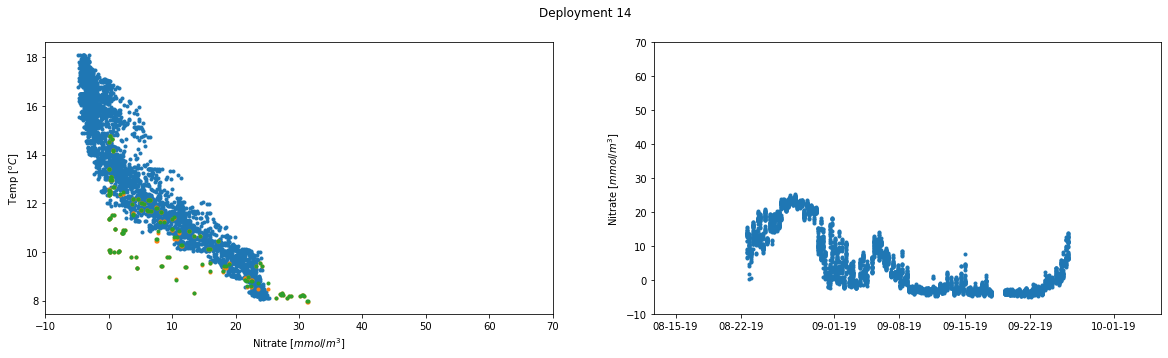

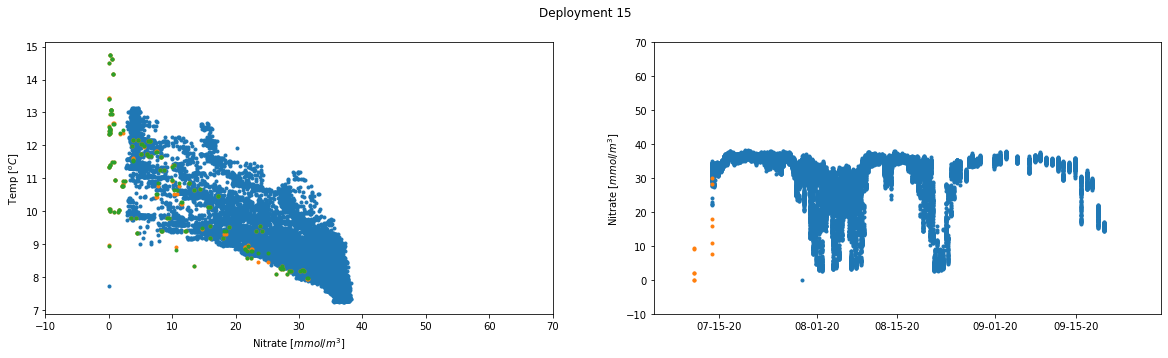

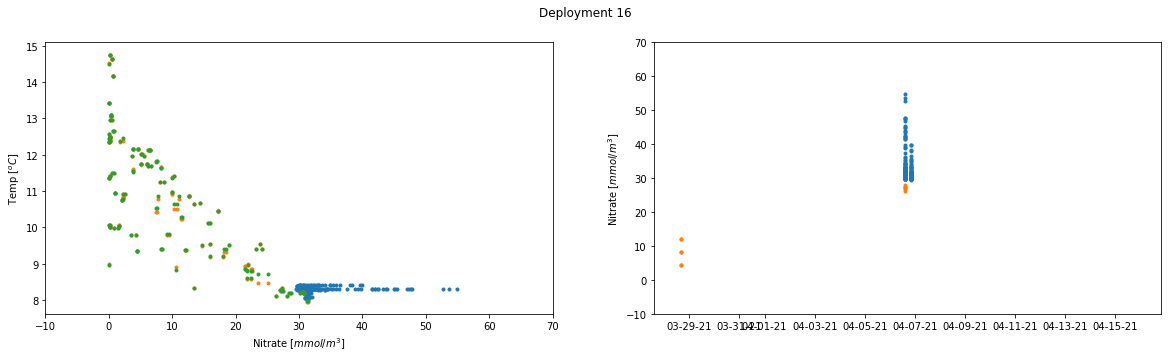

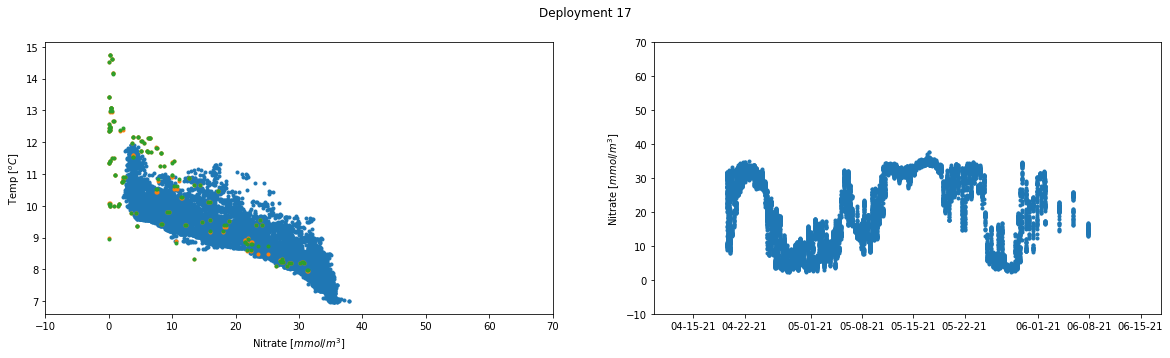

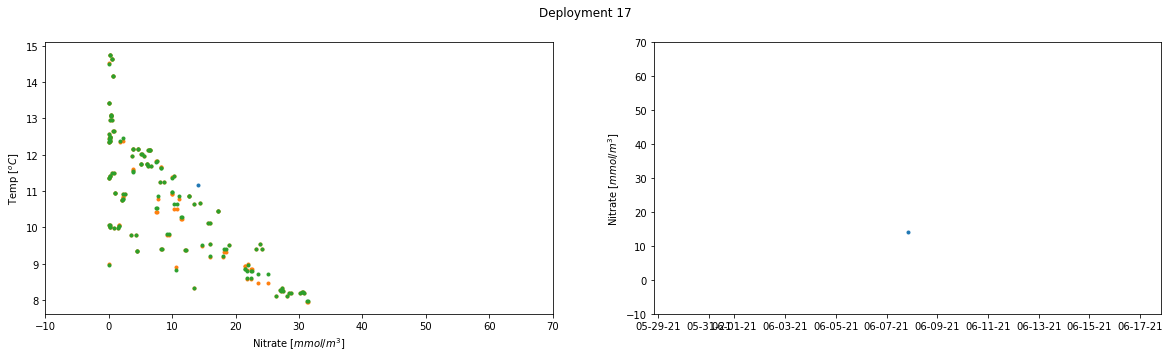

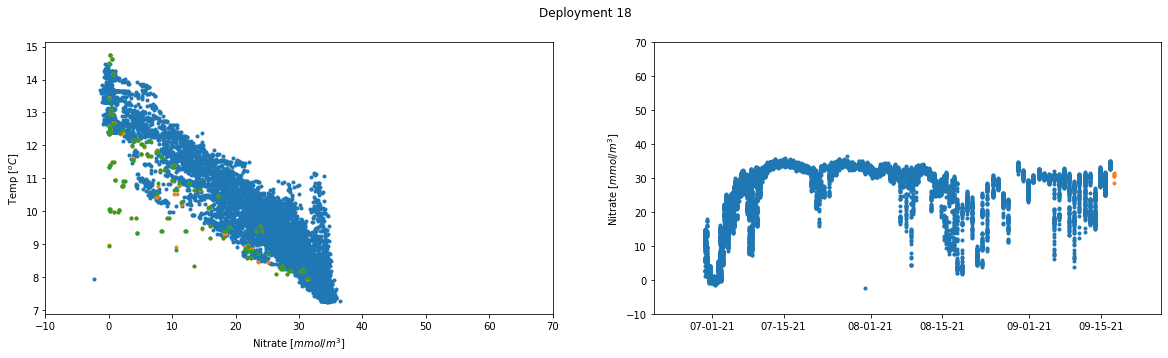

In [72]:
myFmt = DateFormatter("%m-%d-%y")

for i,d in enumerate(ds):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    ax1.plot(d['nitrate_concentration'], d['temperature'],'.')
    ax1.plot(df['Nitrate'][ship_mask], df['Temp1'][ship_mask], '.')
    ax1.plot(df['Nitrate'][ship_mask], df['Temp2'][ship_mask], '.')
    ax2.plot(d['time'], d['nitrate_concentration'], '.')
    ax2.plot(df['Time'][ship_mask], df['Nitrate'][ship_mask], '.')
    fig.suptitle('Deployment %i' %(d['deployment'].values[0]))
    ax1.set_xlabel('Nitrate [$mmol/m^3]$')
    ax1.set_ylabel('Temp [$^oC]$')
    ax2.set_ylabel('Nitrate [$mmol/m^3]$')
    ax1.set_xlim([-10,70])
    ax2.set_ylim([-10,70])
    ax2.set_xlim([dep_sta[i] - np.timedelta64(10, 'D').astype('timedelta64[ns]'), dep_end[i] + np.timedelta64(10, 'D').astype('timedelta64[ns]')])
    ax2.xaxis.set_major_formatter(myFmt)
    #ax2.set_xlim([dep_sta[0],dep_end[-1]])

Text(0, 0.5, 'Nitrate Concentration [$mmol/m^3$]')

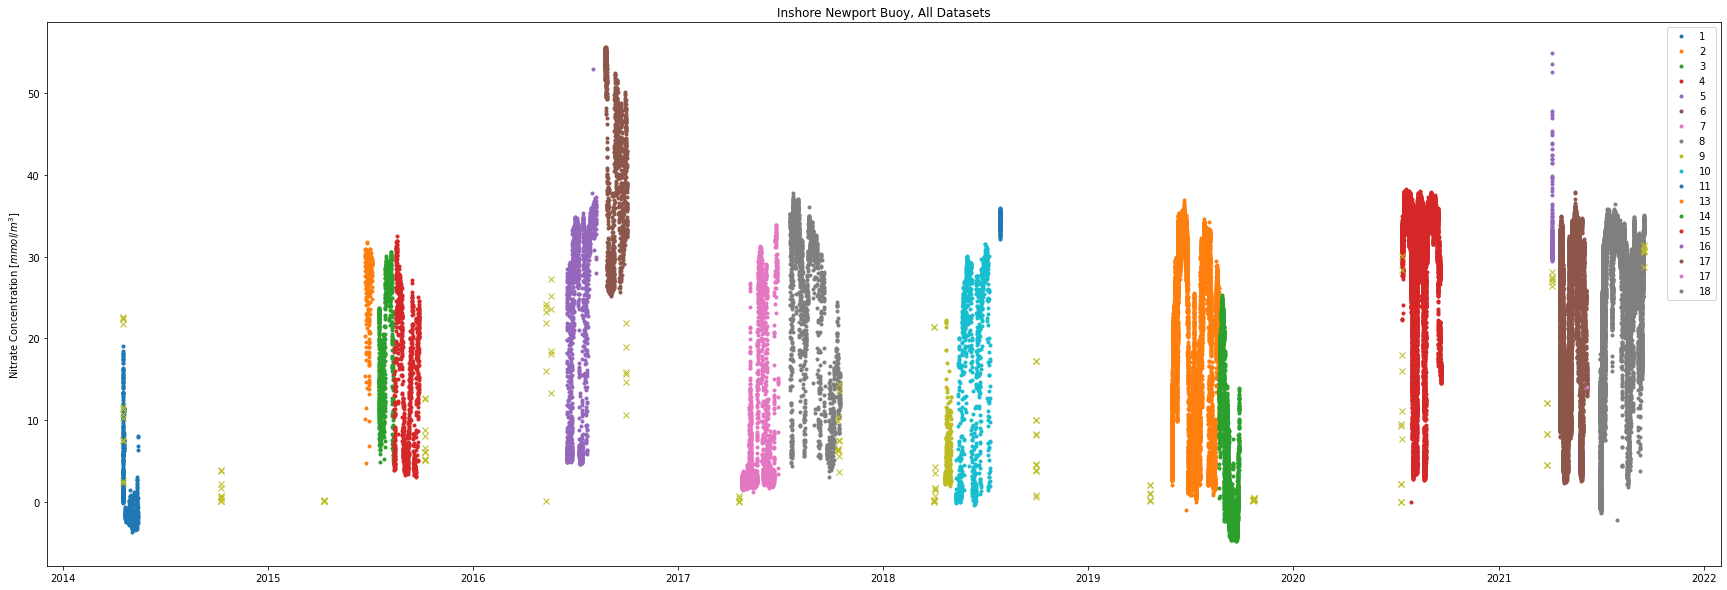

In [73]:
fig = plt.figure(figsize=(30,10))
for i,d in enumerate(ds):
    plt.plot(d['time'][mask[i]], d['nitrate_concentration'][mask[i]], '.', label=labels[i])
plt.plot(df['Time'][ship_mask], df['Nitrate'][ship_mask], 'x')
plt.legend()
plt.title('Inshore Newport Buoy, All Datasets')
plt.ylabel('Nitrate Concentration [$mmol/m^3$]')